# Imports

In [1]:
# Usual stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Typing
from typing import Callable

## Units

We are going to use units where:
- $t = 1$
- $k_B = 1$

# Numerical Methods

In [2]:
def nascent_delta(x: float | np.ndarray, gam: float) -> float | np.ndarray:
    return np.exp(-x * x / (gam * gam)) / (gam * np.sqrt(np.pi))

## Bissection Method

In [3]:
def bissect(func: Callable, a: float, b: float, eps: float = 1e-6, maxI: int = 200, mult: bool = False) -> float:
    """
        Solves the equation `func(x) = 0` using the bissection method in [a, b].

        The function stops when the error is smaller then `eps` or the number of iterations exceeds `maxI`.

        The error is additive by default, but can be made multiplicative by setting `mult` = True

        ### Return
        x: The value of x that solves the equation.
    """

    # Evaluate on the edges
    fa, fb = func(a), func(b)

    # Check if there is a zero on the edges
    if abs(fa) <= 1e-16:
        return a
    elif abs(fb) <= 1e-16:
        return b

    # Main Loop
    i = 0
    error = (b-a)/2

    # For multiplicative error make sure to do at least one iteration
    if mult:
        error = eps + 1

    while abs(error) > eps:

        # Find the midpoint and evaluate the function there
        c = (a+b)/2
        fc = func(c)

        # Check if the zero is exactly on the midpoint
        if abs(fc) <= 1e-16:
            return c

        # Sign change happens in [a, c]
        elif fa * fc < 0:
            b = c
            fb = fc
        
        # Sign change happens in [c, b]
        elif fc * fb < 0:
            a = c
            fa = fc
        
        # No sign change
        else:
            raise ValueError(f"O sinal de f é o mesmo em a = {a} e em b = {b} (f(a) = {fa}, f(b) = {fb}) - iteração {i}).")

        # Compute the error
        error = (b - a)/2

        # If the error is multiplicative, compare the error with the midpoint value
        if mult:
            error /= (a+b)/2

        # Maximum number of iterations
        i += 1
        if i > maxI:
            raise ValueError(f"Não foi possível encontrar a raíz da função com a precisão desejada em menos de maxI = {maxI} iterações!")
        
    return (a+b)/2

# Physics 

In [4]:
def energy(kk: np.ndarray):
    """
        Compute the dispersion relation for a given vector `k`.
    """
    return -2 * np.sum(np.cos(kk), axis = 1)

## Fermi Energy $E_F$

We compute the following Formula using Monte Carlo integration:
$$
\begin{align*}
n &= \int_\text{FBZ} \frac{d^d\textbf k}{(2\pi)^d}\  \theta(U_c - (\varepsilon_\textbf k - \varepsilon_\text{min}))
\end{align*}
$$

In [5]:
def fermi(d: int, n: float, mult: int = 2, biss_eps: float = 5e-3, mc_eps: float = 1e-3):
    """
        Compute the Fermi energy or critical interaction `Uc` for `d` dimensions with filling `n`.

        If `mult` == 2 then we obtain the usual Fermi energy.
        If `mult` == 1 then we compute the critical interaction strength.

        Uses the bissection method with error `biss_eps` and Monte Carlo integration with error `mc_eps`.
    """


    def n_test(Uc: float):
        """
            Apply the formula above and determine the values of n predicted by Uc.
        """

        # Initial number of sampled points
        Ns = 100

        # Compute the integral with Ns samples
        k_Ns = 2 * np.pi * (np.random.random((Ns, d)) - 0.5)
        E_Ns = energy(k_Ns)
        I_Ns = np.sum(mult * np.heaviside(Uc - (E_Ns + 2 * d), 0.5)) / Ns

        # Main loop
        eps = mc_eps + 1
        while eps > mc_eps:
            
            # Increase number of samples
            Ns *= 4
            
            # Compute the integral with 4*Ns samples
            k_Ns = 2 * np.pi * (np.random.random((Ns, d)) - 0.5)
            E_Ns = energy(k_Ns)
            I_4Ns = np.sum(mult * np.heaviside(Uc - (E_Ns + 2 * d), 0.5)) / Ns

            # Estimate the error 
            eps = np.abs(I_4Ns - I_Ns)

            # Update for next step
            I_Ns = I_4Ns
        
        return I_4Ns
    
    # Find Uc via bissecion
    Uc = bissect(lambda x: n_test(x) - n, 0, 4 * d, eps = biss_eps)

    return Uc


# print(f"Critical U for n = 0.5 and d = 1: {fermi(1, 0.5, 1)}")
# print(f"Critical U for n = 1.0 and d = 2: {fermi(2, 1.0, 1)}")
# print("")
# print(f"Fermi Energy for n = 0.5 and d = 1: {fermi(1, 0.5, 2, mc_eps=0.25e-2)}")
# print(f"Fermi Energy for n = 1.0 and d = 2: {fermi(2, 1.0, 2, mc_eps=0.25e-2)}")

## Energy $\varepsilon_0$

In [6]:
def eps0(d: int, n: float, U: float, biss_eps: float = 10e-3, mc_eps: float = 4e-3):
    """
        Compute `eps0` for `d` dimensions with filling `n`.

        Uses the bissection method with error `biss_eps` and Monte Carlo integration with error `mc_eps`.
    """


    def n_test(eps0: float):
        """
            Apply the formula above and determine the values of n predicted by Uc.
        """

        # Initial number of sampled points
        Ns = 100

        # Compute the integral with Ns samples
        k_Ns = 2 * np.pi * (np.random.random((Ns, d)) - 0.5)
        E_Ns = energy(k_Ns)
        I_Ns = np.sum(np.heaviside(eps0 + U - (E_Ns + 2 * d), 0.5) + np.heaviside(eps0 - (E_Ns + 2 * d), 0.5)) / Ns

        # Main loop
        eps = mc_eps + 1
        while eps > mc_eps:
            
            # Increase number of samples
            Ns *= 4
            
            # Compute the integral with 4*Ns samples
            k_Ns = 2 * np.pi * (np.random.random((Ns, d)) - 0.5)
            E_Ns = energy(k_Ns)
            I_4Ns = np.sum(np.heaviside(eps0 + U - (E_Ns + 2 * d), 0.5) + np.heaviside(eps0 - (E_Ns + 2 * d), 0.5)) / Ns

            # Estimate the error 
            eps = np.abs(I_4Ns - I_Ns)

            # Update for next step
            I_Ns = I_4Ns
        
        return I_4Ns
    
    # Find eps0 via bissecion
    eps0 = bissect(lambda x: n_test(x) - n, 0, 4 * d, eps = biss_eps)

    return eps0


# print(f"Eps0 for U = 1, n = 0.5 and d = 1: {eps0(1, 0.5, 1)}")
# print(f"Eps0 for U = 2, n = 1.0 and d = 1: {eps0(1, 1.0, 2)}")

# Main Code

We will compute the critical temperature, by determining at which temperature $\chi_0(0) = 1/g$:
$$
\begin{align*}

\chi_0(0) &= \int d\omega\ N'(\omega) \cdot \frac{\tanh \frac{\beta \omega}{2}}{2\omega}

\end{align*}
$$

Where:
- $N'(\omega)$ is an effective density of states:
    $$
    \begin{align*}
    
    N'(\omega) &= \frac1{L_d}\left(\sum_{\textbf k \in \Omega_0} \delta(\omega - \xi_\textbf k^l) + \sum_{\textbf k \in \Omega_2} \delta(\omega - \xi_\textbf k^u) + \frac14\sum_{\textbf k \in \Omega_1} \delta(\omega - \xi_\textbf k^l)  +\delta(\omega - \xi_\textbf k^u) \right)
    
    \end{align*}
    $$
    
- $\xi_\textbf k$ is given by:
    $$
    \begin{align*}
    
    \xi_\textbf k^u &= \xi_\textbf k + U
    \\\\
    
    \xi_\textbf k^l &= \xi_\textbf k
    
    \end{align*}
    $$

## Zero Temperature calculation of $\lang n_{\textbf k \sigma}\rang$ $\rarr$ Not useful

At $T=0$ we have:
- For $U < 0$ we have:
    $$
        \begin{align*}
            \langle n_{k\uparrow} \rangle = \langle n_{k\downarrow} \rangle =
            \begin{cases}
            1 & \varepsilon_k \le E_F \\[6pt]
            0 & \text{otherwise}
            \end{cases}
        \end{align*}
    $$

- For $0 < U < U_c$ we have:
    $$
        \begin{align*}
            \langle n_{k\uparrow} \rangle = \langle n_{k\downarrow} \rangle =
            \begin{cases}
            1 & \varepsilon_k \le \varepsilon_0 \\[6pt]
            \frac{1}{2} & \varepsilon_0 < \varepsilon_k \le \varepsilon_0 + U \\[6pt]
            0 & \varepsilon_0 + U < \varepsilon_k
            \end{cases}
        \end{align*}
    $$

- For $U > U_c$ we have:
    $$
        \begin{align*}

            \langle n_{k\uparrow} \rangle = \langle n_{k\downarrow} \rangle =
            \begin{cases}

            \frac{1}{2} & \varepsilon_\textbf k \le U_c \\[6pt]
            0 & \text{otherwise}
            \end{cases}

        \end{align*}
    $$

In [7]:
def bigomegaT0(d: int, n: float, U: float, mesh_ek: np.ndarray, mesh_kk: np.ndarray):
    """
        Compute the regions of the FBZ which have occupation 0, 1 or 2.
    """

    # Bandwith and minimum energy
    W = 4 * d
    emin = -W/2

    # Pre-compute model properties
    Ef = fermi(d, n, 2)
    Uc = fermi(d, n, 1)
    e0 = eps0(d, n, U)

    # Difference from energy minimum
    mesh_deltaek = mesh_ek - emin

    # Transpose to save in the omega lists
    mesh_kk = mesh_kk.T

    # Omega regions
    omega_0 = np.zeros_like(mesh_ek)
    omega_1 = np.zeros_like(mesh_ek)
    omega_2 = np.zeros_like(mesh_ek)

    
    # Attractive Case
    if U <= 0:

        # If ek <= Ef then Omega = 2 else Omega = 0
        omega_2 = (mesh_deltaek <= Ef)
        omega_0 = ~omega_2
    

    # Weakly Repeling case
    elif U < Uc:
        
        # If ek <= e0 then Omega = 2 else if e0 < ek < e0 + U then OMega = 1 else Omega = 0
        omega_2 = (mesh_deltaek <= e0)
        omega_1 = ((e0 < mesh_deltaek) & (mesh_deltaek < (e0 + U)))
        omega_0 = ~(omega_2 | omega_1)
        
    
    # Strongly Repeling case
    else:
        
        # If ek <= Uc then Omega = 1 else Omega = 0
        omega_1 = (mesh_deltaek <= Uc)
        omega_0 = ~(omega_1)

    return omega_0, omega_1, omega_2


# omega_0, omega_1, omega_2 = bigomega(1, 1, 12, 2)

In [8]:
def TcT0(d: int, n: float, V: int, U: float, gam: float, Wnum: int, g: float, biss_eps: float = 1e-6):
    """
        Computes Tc using the T = 0 regions Omega0, Omega1 and Omega2
    """

    # STAGE 0: Preparation

    # Bandwith and minimum energy
    W = 4 * d

    # Determine values of k in our lattice
    L = int(np.ceil(V**(1/d)))
    kk = np.linspace(-np.pi, np.pi, L + 1, retstep=False)[:-1]

    # Make a mesh of k values
    grid_kk = np.meshgrid(*[kk]*d, indexing='ij')

    # Convert to a single array with shape (d, len(kk) ** d)
    mesh_kk = np.stack(grid_kk).reshape(d, len(kk) ** d).T

    # Get the energy for each k
    mesh_ek = energy(mesh_kk)

    # Update V according to rounding
    V = len(mesh_ek)

    # Grid in omega
    Wmin = U - W/2 - 3
    Wmax = U + W/2 + 3

    mesh_ww = np.linspace(Wmin, Wmax, Wnum)

    # Make a mesh with points (ek, omega)
    mesh_cek, mesh_cww = np.meshgrid(mesh_ek, mesh_ww)

    # Brillouin zone areas
    omega_0, omega_1, omega_2 = bigomegaT0(d, n, U, mesh_ek, mesh_kk)


    # STAGE 1: Compute A(omega)

    # K-dependent spectral function
    Akw = (1.0 * (omega_0 > 0) + 0.5 * (omega_1 > 0)) * nascent_delta(mesh_cww - mesh_cek, gam) + (1.0 * (omega_2 > 0) + 0.5 * (omega_1 > 0)) * nascent_delta(mesh_cww - mesh_cek - U, gam)
    
    # Sum along K-axis
    Aw = np.sum(Akw, axis=1)


    # STAGE 2: Compute mu

    # Integrate DOS 
    h = mesh_ww[1] - mesh_ww[0]
    trap = (Aw[:-1] + Aw[1:]) / 2
    idos = h * np.concatenate((np.array([0]), trap.cumsum()))

    # Normalize to 2
    ndos = (2 / idos[-1])
    idos *= ndos

    # Highest filled state and lowest empty state
    filled = mesh_ww[idos <= n]
    empty = mesh_ww[idos >= n]

    # Determine chemical potential at T = 0
    # It is midway between the last filled level and last unfilled level
    mu = 0.5 * (filled[-1] + empty[0])

    # Update energy dispersion
    mesh_xk = mesh_ek - mu

    print(f"mu = {mu}")
    print(f"len0 = {np.sum(omega_0)} | len1 = {np.sum(omega_1)} | len2 = {np.sum(omega_2)}")


    # Do the function tanh(x)/x using the correct limit as x -> 0
    def tanhoverx(beta: float, xx: np.ndarray):
        
        # Mask for small values of x
        small = np.isclose(xx, 0.0)

        # Output (normal for ~small and analytic limit for small)
        out = np.empty_like(xx, dtype=float)
        out[~small] = np.tanh(beta * xx[~small] / 2.0) / (2.0 * xx[~small])
        out[small] = beta / 4.0

        return out
    

    def chi0T0(T: float):
        
        # Thermodynamic temperature
        beta = 1/T

        # STAGE 3: Compute chi0(0)
        chi0l = np.sum((1.0 * (omega_0 > 0) + 0.25 * (omega_1 > 0)) * tanhoverx(beta, mesh_xk))
        chi0u = np.sum((1.0 * (omega_2 > 0) + 0.25 * (omega_1 > 0)) * tanhoverx(beta, mesh_xk + U))

        return (chi0l + chi0u) / V


    # Compute Tc
    Tc = bissect(lambda T: chi0T0(T) - 1/g, 1e-9, 1e-2, biss_eps)

    return Tc



# PARAMETERS

# Model
d = 1
n = 1
V = 6000

W = 4 * d
U = 0.6 * W
g = 0.1 * W


# Calculations 
gam = 0.03
Wnum = 2000

# print(TcT0(d, n, V, U, gam, Wnum, g))

# out:
# mu = 1.1893946973486742
# len0 = 1803 | len1 = 2458 | len2 = 1739
# 0.0001385507908325195

## Finite Temperature calculation of $\lang n_{\textbf k \sigma}\rang$ $\rarr$ Useful

### Occupation Regions

We take a look at the occupation of the different portions of the BZ.

In [9]:
def bigomegaT0(U: float, mesh_xk: np.ndarray):
    """
        Compute the regions of the FBZ which have occupation 0, 1 or 2 at T = 0.
        
        The argument `mesh_xk` is the mesh of energies xi = eps - mu.
    """

    # Omega regions
    mesh_nk = np.zeros_like(mesh_xk)
    omega_0 = np.zeros_like(mesh_xk)
    omega_1 = np.zeros_like(mesh_xk)
    omega_2 = np.zeros_like(mesh_xk)

    # We have double occupation if upper Hubbard band (UHB) is below chemical potential
    omega_2 = (mesh_xk + U) < 0

    # We have empty states if lower Hubbard band (LHB) is above the chemical potential
    omega_0 = mesh_xk > 0

    # Otherwise we have single-filled states
    omega_1 = ~(omega_0 | omega_2)

    # Build mesh_nk
    mesh_nk[omega_0] = 0
    mesh_nk[omega_1] = 1/2
    mesh_nk[omega_2] = 1


    return mesh_nk, omega_0, omega_1, omega_2


def occupations(U: float, beta: float, mesh_xk: np.ndarray, cutoff: float = 30):
    """
        Compute the average occupation of each state.
    """

    # Omega regions
    mesh_nk = np.zeros_like(mesh_xk)

    # Arguments of exponentials
    arg_zk = -beta * mesh_xk
    arg_zk1U = -beta * (mesh_xk + U)
    arg_zk2U = -beta * (2 * mesh_xk + U)

    # Determine when the approximate formula is required
    approx = arg_zk > cutoff

    # Clip to prevent overflow errors
    arg_zk = np.clip(arg_zk, -700, 700)
    arg_zk1U = np.clip(arg_zk1U, -700, 700)
    arg_zk2U = np.clip(arg_zk2U, -700, 700)

    # Use the approximate formula
    mesh_nk[approx] = 1 - 1 / (2 + np.exp(arg_zk1U[approx]))

    # Compute log(1 - nk)
    mesh_zk = np.exp(arg_zk)
    mesh_nk[~approx] = np.log1p(mesh_zk[~approx]) - np.log1p(2 * mesh_zk[~approx] + np.exp(arg_zk2U[~approx]))

    # Compute nk
    mesh_nk[~approx] = 1 - np.exp(mesh_nk[~approx])

    return mesh_nk

### Average Occupation

We use the following formulas to compute the average occupation:
\begin{align*}
&\ \lang n_{\textbf k \sigma}\rang = 1 - \frac{1 + z_\textbf k}{1 + 2z_\textbf k + z_\textbf k^2 e^{-\beta U}} 
\\\\
\hArr&\ \log(1-\lang n_{\textbf k \sigma}\rang) = \log(1 + z_\textbf k) - \log(1 + 2z_\textbf k + z_\textbf k^2 e^{-\beta U})
\end{align*}

If $-\beta \xi_\textbf k \gg 1$ then its exponential will be large, hence:
\begin{align*}
\log(1-\lang n_{\textbf k \sigma}\rang) &\approx \log(z_\textbf k) - \log(2z_\textbf k + z_\textbf k^2 e^{-\beta U})
\\\\
&= - \log(2 + z_\textbf k e^{-\beta U})
\end{align*}

Which means that we can use:
\begin{align*}
&\ \lang n_{\textbf k \sigma}\rang = 1 - \frac{1}{2 + z_\textbf k e^{-\beta U}} 
\end{align*}

### Helper Function

In [10]:
# Do the function tanh(x)/x using the correct limit as x -> 0
def tanhoverx(beta: float, xx: np.ndarray):
    
    # Mask for small values of x
    small = np.abs(xx) < 1e-7

    # Output (normal for ~small and analytic limit for small)
    out = np.empty_like(xx, dtype=float)
    out[~small] = np.tanh(beta * xx[~small] / 2.0) / (2.0 * xx[~small])
    out[small] = beta / 4.0

    return out

### Main Code for $T_c$

In [11]:
def TcTf(d: int, n: float, V: int, U: float, g: float, mu_eps: float = 2e-4, Tc_eps: float = 2e-2, Tc_min: float = 1e-7, Tc_max: float = 1e-1, dwave: bool = False):
    """
        Computes Tc using finite temperature values of nk.

        The error parameters are:
        - `mu_eps` is the linear error on the chemical potential
        - `Tc_eps` is the multiplicative error on the critical temperature
    """

    # STAGE 0: Preparation

    # Bandwith and minimum energy
    W = 4 * d

    # Determine values of k in our lattice
    L = int(np.ceil(V**(1/d)))
    kk = np.linspace(-np.pi, np.pi, L + 1, retstep=False)[:-1]

    # Make a mesh of k values
    grid_kk = np.meshgrid(*[kk]*d, indexing='ij')

    # Convert to a single array with shape (len(kk) ** d, d)
    mesh_kk = np.stack(grid_kk).reshape(d, len(kk) ** d).T

    # Get the energy for each k
    mesh_ek = energy(mesh_kk)

    # Update V according to rounding
    V = len(mesh_ek)

    def chi0(T: float):

        # STEP 1: Solve self-consistently for mu at this beta
        beta = 1/T

        # Minimum and maximum mu are below the bands by T (so that they correspond to completely empty and completely full)
        mu_min = -U - W - 1/beta
        mu_max = U + W + 1/beta

        # Compute total occupation n(mu)
        def n_test(mu: float):

            # Occupation numbers
            mesh_nk = occupations(U, beta, mesh_ek - mu)

            return 2 * np.sum(mesh_nk) / V
    
        # Determine mu via bissection
        mu = bissect(lambda x: n_test(x) - n, mu_min, mu_max, mu_eps)


        # STEP 2: Use the mu we found to compute occupations and chi0

        # Occupation numbers
        mesh_nk = occupations(U, beta, mesh_ek - mu)

        # Plot (debugging)
        # if beta >= 1e6:
        #     print(f"beta = {beta}")
        #     print(f"mu = {mu}")
        #     plt.plot(mesh_ek, mesh_nk)
        #     plt.show()

        # Compute l and u terms
        mesh_nu = mesh_nk
        mesh_nl = 1 - mesh_nk

        mesh_xl = mesh_ek - mu
        mesh_xu = mesh_ek - mu + U

        # Compute form factor
        Vk = np.ones_like(mesh_nk)
        if dwave:
            Vk = np.cos(mesh_kk[:, 0]) - np.cos(mesh_kk[:, 1])

        # Compute direct terms
        chi_ll = (Vk**2) * mesh_nl * mesh_nl * tanhoverx(beta, mesh_xl)
        chi_uu = (Vk**2) * mesh_nu * mesh_nu * tanhoverx(beta, mesh_xu)

        # print(f"mesh_nk.shape = {mesh_nk.shape}")
        # print(f"mesh_kk.shape = {mesh_kk.shape}")
        # print(f"average_Vk = {np.average(Vk)}, max_Vk = {np.max(Vk)}, min_V = {np.min(Vk)}, average^2 = {np.average(Vk**2)}")

        # if beta >= 1e3:
        #     print(f"mu = {mu}")
        #     print(f"beta = {beta}")

        #     print(f"chi_ll = {np.sum(chi_ll)}")
        #     print(f"chi_uu = {np.sum(chi_uu)}")
        #     print(f"chi_0 = {(np.sum(chi_ll) + np.sum(chi_uu)) / V}")

        #     plt.plot(mesh_ek, mesh_nu, label="nu")
        #     plt.plot(mesh_ek, mesh_nl, label="nl")
        #     plt.legend()
        #     plt.show()

        # Compute cross terms
        # arg_ul = np.log1p(-np.exp(np.clip(-beta * (2 * mesh_xl + U), -700, 700))) - np.log1p(np.exp(np.clip(-beta * mesh_xl, -700, 700))) - np.log1p(np.exp(np.clip(-beta * mesh_xu, -700, 700)))
        # arg_ul = np.clip(arg_ul, -700, 700)

        # num_ul = np.exp(arg_ul)
        # chi_ul = 2 * mesh_nl * mesh_nu * num_ul / (2 * mesh_xl + U)

        # print(f"chi_ll = {np.sum(chi_ll)}, chi_uu = {np.sum(chi_uu)}, chi_ul = {np.sum(chi_ul)}")

        return (np.sum(chi_ll) + np.sum(chi_uu)) / V
    

    # tt = 10 ** (-np.linspace(1, 9, 100))
    # cc = np.array([chi0(T) for T in tt])
    # plt.title("Chi0(T) - 1/g")
    # plt.plot(tt, cc - 1/g)
    # plt.xscale("log")
    # plt.show()

    # Find the order of magnitude of Tc
        

    # Compute Tc with multiplicative error
    Tc = bissect(lambda T: chi0(T) - 1/g, Tc_min, Tc_max, eps = Tc_eps, mult = True)

    return Tc

### Color Plot

Step 1/11: computing for U / W = 0.9
Progress: 16/16 with success for 16/16
Step 2/11: computing for U / W = 1.0
Progress: 16/16 with success for 16/16
Step 3/11: computing for U / W = 1.0
Progress: 16/16 with success for 16/16
Step 4/11: computing for U / W = 1.0
Progress: 16/16 with success for 16/16
Step 5/11: computing for U / W = 1.0
Progress: 16/16 with success for 16/16
Step 6/11: computing for U / W = 1.0
Progress: 16/16 with success for 16/16
Step 7/11: computing for U / W = 1.0
Progress: 16/16 with success for 16/16
Step 8/11: computing for U / W = 1.0
Progress: 16/16 with success for 15/16
Step 9/11: computing for U / W = 1.0
Progress: 16/16 with success for 15/16
Step 10/11: computing for U / W = 1.0
Progress: 16/16 with success for 15/16
Step 11/11: computing for U / W = 1.1
Progress: 16/16 with success for 15/16


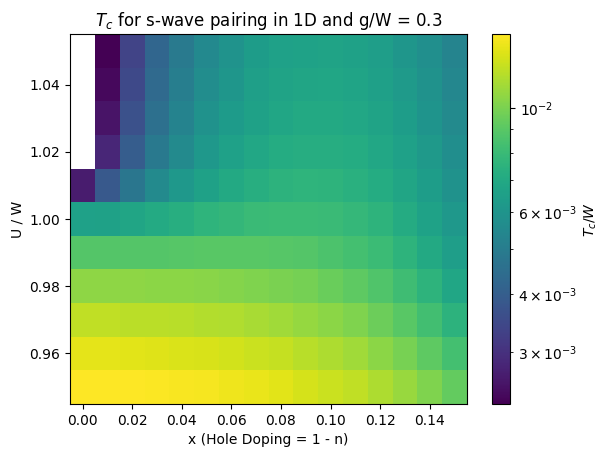

In [19]:
# PARAMETERS

# Model
d = 1
W = 4 * d

V = 100_000
g = 0.1 * W

dwave = False


# Search area
Tc_min = 1e-6 * W
Tc_max = 2e-1 * W


# Errors
mu_eps = 1e-4
Tc_eps = 5e-3


# Filling
x_min = 0
x_max = 0.15
x_ste = 16

xx = np.linspace(x_min, x_max, x_ste)


# Hubbard 
u_min = 0.95 * W
u_max = 1.05 * W
u_ste = 11

uu = np.linspace(u_min, u_max, u_ste)

uu_mesh, xx_mesh = np.meshgrid(uu, xx)

# Calculations
for g in np.array([0.3]) * W:
    tt_mesh = np.zeros_like(uu_mesh)
    for iu, U in enumerate(uu):

        print(f"Step {iu + 1}/{u_ste}: computing for U / W = {U / W:.1f}")

        succ = 0
        for im, x in enumerate(xx):
            # Filling factor
            n = 1 - x

            # Try to compute Tc
            try:
                tt_mesh[im, iu] = TcTf(d, n, V, U, g, mu_eps=mu_eps, Tc_min=Tc_min, Tc_max=Tc_max, Tc_eps=Tc_eps, dwave=dwave) / W
                succ += 1
            except ValueError as e:
                # Set result to invalid
                tt_mesh[im, iu] = 0

                # Debugging
                # print(e)

            # Show progress
            print(f"\rProgress: {im + 1}/{x_ste} with success for {succ}/{x_ste}", end="")

        # Reset print
        print("")

    plt.title(f"$T_c$ for {'d-wave' if dwave else 's-wave'} pairing in {d}D and g/W = {g/W:.1f}")
    plt.pcolormesh(xx_mesh, uu_mesh / W, tt_mesh, cmap="viridis", norm=colors.LogNorm(vmin=np.min(tt_mesh[tt_mesh > 0]), vmax=np.max(tt_mesh)))
    plt.colorbar(label="$T_c / W$")
    plt.xlabel("x (Hole Doping = 1 - n)")
    plt.ylabel("U / W")
    plt.show()

Step 1/11: computing for U / W = 0.0
Progress: 26/26 with success for 26/26
Step 2/11: computing for U / W = 0.2
Progress: 26/26 with success for 26/26
Step 3/11: computing for U / W = 0.4
Progress: 26/26 with success for 26/26
Step 4/11: computing for U / W = 0.6
Progress: 26/26 with success for 26/26
Step 5/11: computing for U / W = 0.8
Progress: 26/26 with success for 26/26
Step 6/11: computing for U / W = 1.0
Progress: 26/26 with success for 25/26
Step 7/11: computing for U / W = 1.2
Progress: 26/26 with success for 25/26
Step 8/11: computing for U / W = 1.4
Progress: 26/26 with success for 24/26
Step 9/11: computing for U / W = 1.6
Progress: 26/26 with success for 25/26
Step 10/11: computing for U / W = 1.8
Progress: 26/26 with success for 25/26
Step 11/11: computing for U / W = 2.0
Progress: 26/26 with success for 25/26


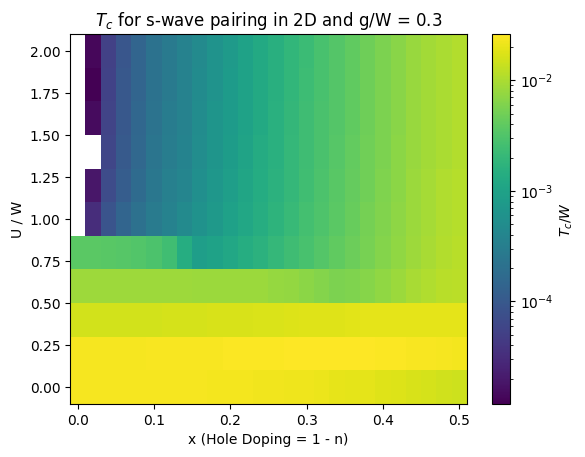

In [ ]:
# PARAMETERS

# Model
d = 2
W = 4 * d

V = 200_000
g = 0.1 * W

dwave = False


# Search area
Tc_min = 1e-6 * W
Tc_max = 1e-1 * W


# Errors
mu_eps = 2e-4
Tc_eps = 2e-2


# Filling
x_min = 0
x_max = 0.50
x_ste = 26

xx = np.linspace(x_min, x_max, x_ste)


# Hubbard 
u_min = 0
u_max = 2.0 * W
u_ste = 11

uu = np.linspace(u_min, u_max, u_ste)

uu_mesh, xx_mesh = np.meshgrid(uu, xx)

# Calculations
for g in np.array([0.3]) * W:
    tt_mesh = np.zeros_like(uu_mesh)
    for iu, U in enumerate(uu):

        print(f"Step {iu + 1}/{u_ste}: computing for U / W = {U / W:.1f}")

        succ = 0
        for im, x in enumerate(xx):
            # Filling factor
            n = 1 - x

            # Try to compute Tc
            try:
                tt_mesh[im, iu] = TcTf(d, n, V, U, g, mu_eps=mu_eps, Tc_min=Tc_min, Tc_max=Tc_max, Tc_eps=Tc_eps, dwave=dwave) / W
                succ += 1
            except ValueError as e:
                # Set result to invalid
                tt_mesh[im, iu] = 0

                # Debugging
                # print(e)

            # Show progress
            print(f"\rProgress: {im + 1}/{x_ste} with success for {succ}/{x_ste}", end="")

        # Reset print
        print("")

    plt.title(f"$T_c$ for {'d-wave' if dwave else 's-wave'} pairing in {d}D and g/W = {g/W:.1f}")
    plt.pcolormesh(xx_mesh, uu_mesh / W, tt_mesh, cmap="viridis", norm=colors.LogNorm(vmin=np.min(tt_mesh[tt_mesh > 0]), vmax=np.max(tt_mesh)))
    plt.colorbar(label="$T_c / W$")
    plt.xlabel("x (Hole Doping = 1 - n)")
    plt.ylabel("U / W")
    plt.show()

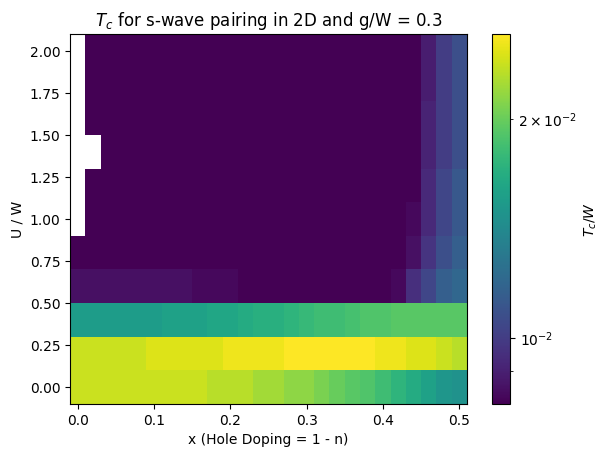

In [24]:
plt.title(f"$T_c$ for {'d-wave' if dwave else 's-wave'} pairing in {d}D and g/W = {g/W:.1f}")
plt.pcolormesh(xx_mesh, uu_mesh / W, tt_mesh, cmap="viridis", norm=colors.LogNorm(vmin=np.min(tt_mesh[tt_mesh > 8e-3]), vmax=np.max(tt_mesh)))
plt.colorbar(label="$T_c / W$")
plt.xlabel("x (Hole Doping = 1 - n)")
plt.ylabel("U / W")
plt.show()

### Line Plot

In [ ]:
# PARAMETERS

# Model
d = 1
W = 4 * d

V = 100_000
g = 0.1 * W

dwave = False


# Search area
Tc_min = 1e-5
Tc_max = 1e-2


# Errors
mu_eps = 2e-4
Tc_eps = 1e-2


# Compute
x_min = 0
x_max = 0.50
x_ste = 50

xx = np.linspace(x_min, x_max, x_ste)


# Interactions
uu = np.array([0.6, 0.8, 0.9, 1.0, 1.2]) * W
for U in uu:
    print(f"Computing for U / W = {U / W:.1f}")

    tt_mesh = np.zeros_like(xx)
    succ = 0
    for index, x in enumerate(xx):
        # Filling factor
        n = 1 - x

        # Try to compute Tc
        try:
            tt_mesh[index] = TcTf(d, n, V, U, g, mu_eps=mu_eps, Tc_min=Tc_min, Tc_max=Tc_max, Tc_eps=Tc_eps, dwave=dwave) / W
            succ += 1
        except ValueError as e:
            # Set result to invalid
            tt_mesh[index] = -1

            # Debugging
            # print(e)

        # Show progress
        print(f"\rProgress: {index + 1}/{x_ste} with success for {succ}/{x_ste}", end="")

    # Reset print
    print("")

    # Valid critical temperatures
    valid = tt_mesh > 0

    # Plot
    plt.plot(xx[valid], tt_mesh[valid], label = f"U / W = {U / W:.1f}")

plt.title(f"$T_c$ for {'d-wave' if dwave else 's-wave'} pairing for V = {V}, d = {d} and g/W = {g/W:.1f}")
plt.xlabel("x (Hole Doping)")
plt.ylabel("$T_c$ / W")
plt.yscale("log")
plt.ylim(Tc_min, Tc_max)
plt.legend()
plt.show()

Computing for U / W = 0.6
Progress: 7/50 with success for 7/50

KeyboardInterrupt: 